# Prerequisites

### HuggingFace Config

In [ ]:
hub_model_id="xxxxx"
hub_token="xxxxx",

### WandB config

In [ ]:
import os
import wandb

#WandB API key
os.environ['WANDB_API_KEY'] = 'xxxxx'

#Initialise wandb project
wandb.init(project="ModernFINBERT_financial_sentiment_GPU")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: draoi. Use `wandb login --relogin` to force relogin


### Imports

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install evaluate
!pip install datasets
!pip install accelerate -U
!pip install optuna
!pip install ray

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qdus643i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-qdus643i
  Resolved https://github.com/huggingface/transformers.git to commit 34f76bb62b915b43617aa88557aea97840e163f0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10470900 sha256=3d234ac725e0d8f32bb94344bddf4be0395c064752dc68e3ecab243f6ae67b34
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvv1aop8/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)


### Are we on a GPU?

In [ ]:
import torch
print(torch.cuda.is_available())

True


# Data Preperation

## Financial Phrasebank Dataset

### Download and unzip dataset

In [ ]:
!wget -nc https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip -O FinancialPhraseBank-v1.0.zip
!unzip -n FinancialPhraseBank-v1.0.zip

--2025-01-14 01:43:14--  https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/datasets/financial_phrasebank/0e1a06c4900fdae46091d031068601e3773ba067c7cecb5b0da1dcba5ce989a6?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27FinancialPhraseBank-v1.0.zip%3B+filename%3D%22FinancialPhraseBank-v1.0.zip%22%3B&response-content-type=application%2Fzip&Expires=1737078194&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzA3ODE5NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kYXRhc2V0cy9maW5hbmNpYWxfcGhyYXNlYmFuay8wZTFhMDZjNDkwMGZkYWU0NjA5MWQwMzEwNjg2MDFlMzc3M2JhMDY3YzdjZWNiNWIwZGExZGNiYTVjZTk4OWE2P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249

In [ ]:
!pip install chardet

In [ ]:
!python -m chardet /content/FinancialPhraseBank-v1.0/Sentences_50Agree.txt

/content/FinancialPhraseBank-v1.0/Sentences_50Agree.txt: ISO-8859-1 with confidence 0.7299541577952681


In [ ]:
with open('/content/FinancialPhraseBank-v1.0/Sentences_50Agree.txt', 'r', encoding='ISO-8859-1') as f:
    for i in range(5):
        line = f.readline().strip()
        print(line)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral
Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .@neutral
The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .@negative
With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .@positive
According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .@positiv

### Parse Data

In [ ]:
import pandas as pd

texts = []
labels = []

with open('/content/FinancialPhraseBank-v1.0/Sentences_50Agree.txt', 'r', encoding='ISO-8859-1') as f:
    for line in f:
        line = line.strip()
        # Split line into text and label
        text, label = line.rsplit('@', 1)
        text = text.strip()
        label = label.strip()

        #labels are "@positive", "@negative", or "@neutral"
        #After splitting, if it has '@', remove it
        if label.startswith('@'):
            label = label[1:]

        texts.append(text)
        labels.append(label)

news_df = pd.DataFrame({'text': texts, 'polarity': labels})
news_df.head(), news_df.tail()


(                                                text  polarity
 0  According to Gran , the company has no plans t...   neutral
 1  Technopolis plans to develop in stages an area...   neutral
 2  The international electronic industry company ...  negative
 3  With the new production plant the company woul...  positive
 4  According to the company 's updated strategy f...  positive,
                                                    text  polarity
 4841  LONDON MarketWatch -- Share prices ended lower...  negative
 4842  Rinkuskiai 's beer sales fell by 6.5 per cent ...   neutral
 4843  Operating profit fell to EUR 35.4 mn from EUR ...  negative
 4844  Net sales of the Paper segment decreased to EU...  negative
 4845  Sales in Finland decreased by 10.5 % in Januar...  negative)

In [ ]:
news_df.sample(10)

,text,polarity
595,The company recorded revenues of E658 .1 milli...,positive
3917,The total floor area of the plant expansion is...,neutral
2779,Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEME...,neutral
3800,The company plans to increase the unit 's spec...,neutral
3234,The duration of the contract is 37 months .,neutral
2560,"says Brian Burton , Head of IT Security , Voda...",neutral
1878,We are very excited working with Maxis on this...,positive
1436,The trucks feature an Eco Drive system - a fue...,neutral
2995,Kaleva Kustannus Oy ( business ID 0187274-0 ) ...,neutral
3325,"The Point Village , designed by Scott Tallon W...",neutral


### How balanced is the data?

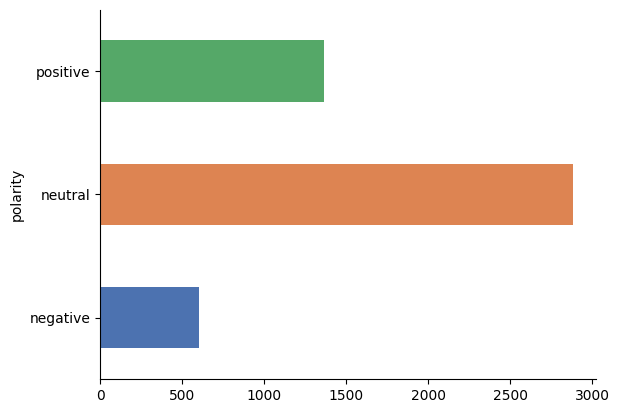

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

news_df.groupby('polarity').size().plot(kind='barh', color=sns.color_palette("deep"))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [ ]:
news_df['polarity'].value_counts()

,count
polarity,
neutral,2879
positive,1363
negative,604


## Twitter Financial Sentiment Dataset

### Download dataset

In [ ]:
!wget nc https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/resolve/main/sent_train.csv
!wget nc https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/resolve/main/sent_valid.csv

--2025-01-14 01:43:27--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2025-01-14 01:43:28--  https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/resolve/main/sent_train.csv
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.55, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 858645 (839K) [text/plain]
Saving to: ‘sent_train.csv’

sent_train.csv      100%[===================>] 838.52K  --.-KB/s    in 0.1s    

2025-01-14 01:43:28 (6.07 MB/s) - ‘sent_train.csv’ saved [858645/858645]

FINISHED --2025-01-14 01:43:28--
Total wall clock time: 0.5s
Downloaded: 1 files, 839K in 0.1s (6.07 MB/s)
--2025-01-14 01:43:28--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2025-01-14 01:43:28--  https://hugg

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/sent_train.csv')
valid_df = pd.read_csv('/content/sent_valid.csv')

train_df.head(), valid_df.head()

(                                                text  label
 0  $BYND - JPMorgan reels in expectations on Beyo...      0
 1  $CCL $RCL - Nomura points to bookings weakness...      0
 2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
 3  $ESS: BTIG Research cuts to Neutral https://t....      0
 4  $FNKO - Funko slides after Piper Jaffray PT cu...      0,
                                                 text  label
 0  $ALLY - Ally Financial pulls outlook https://t...      0
 1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
 2  $PRTY - Moody's turns negative on Party City h...      0
 3                   $SAN: Deutsche Bank cuts to Hold      0
 4                  $SITC: Compass Point cuts to Sell      0)

In [ ]:
# Combine the train and validation DataFrames
twitter_df = pd.concat([train_df, valid_df], ignore_index=True)

# Rename columns in the combined DataFrame
twitter_df.rename(columns={'label': 'polarity'}, inplace=True)

# Replace numeric labels with string labels
twitter_df['polarity'] = twitter_df['polarity'].map({0: 'negative', 1: 'positive', 2: 'neutral'})

# Display the first few rows of the combined DataFrame to verify
twitter_df.head(), twitter_df.tail()

(                                                text  polarity
 0  $BYND - JPMorgan reels in expectations on Beyo...  negative
 1  $CCL $RCL - Nomura points to bookings weakness...  negative
 2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...  negative
 3  $ESS: BTIG Research cuts to Neutral https://t....  negative
 4  $FNKO - Funko slides after Piper Jaffray PT cu...  negative,
                                                     text polarity
 11926  Stocks making the biggest moves midday: TD Ame...  neutral
 11927  Stocks making the biggest moves premarket: Fit...  neutral
 11928  Stocks making the biggest moves premarket: Hom...  neutral
 11929  Stocks making the biggest moves premarket: TD ...  neutral
 11930         TCO, NNVC, GPOR and JE among midday movers  neutral)

In [ ]:
twitter_df.sample(10)

,text,polarity
8500,"Does General Mills, Inc. (NYSE:GIS) Have A Goo...",neutral
7085,Stocks on Wall Street ended Thursday's session...,neutral
6500,Global Trade Momentum Rises for First Time in ...,neutral
10923,What is the age of the ‘Instagram face’?,neutral
3784,The consensus of professional forecasters is t...,negative
7748,"Hedge Funds Couldn’t Dump AnaptysBio, Inc. (AN...",negative
9484,$PYX $FARM $TUP - Pyxus International among co...,neutral
799,Delta has decided to temporarily suspend all f...,negative
7119,"""This Brexit failure was founded on lies and h...",neutral
9399,Power Financial soars 9.9% after restructuring...,positive


### How balanced is the data?

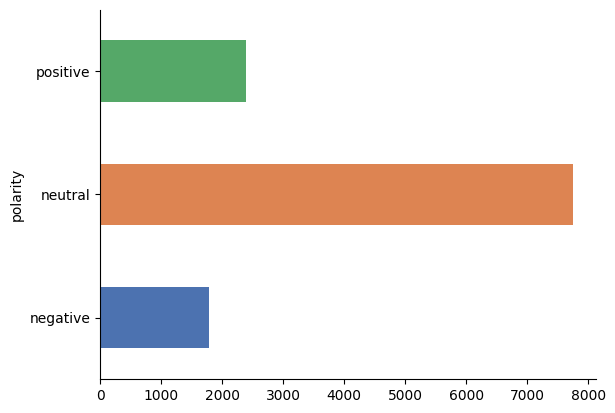

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

twitter_df.groupby('polarity').size().plot(kind='barh', color=sns.color_palette("deep"))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## Combined Dataset

In [ ]:
import pandas as pd

#df1 and df2 have the same column structure, so this will work
combined_df = pd.concat([news_df, twitter_df], ignore_index=True)

# Display the first few rows of the combined DataFrame to verify
combined_df.head(), combined_df.tail()

(                                                text  polarity
 0  According to Gran , the company has no plans t...   neutral
 1  Technopolis plans to develop in stages an area...   neutral
 2  The international electronic industry company ...  negative
 3  With the new production plant the company woul...  positive
 4  According to the company 's updated strategy f...  positive,
                                                     text polarity
 16772  Stocks making the biggest moves midday: TD Ame...  neutral
 16773  Stocks making the biggest moves premarket: Fit...  neutral
 16774  Stocks making the biggest moves premarket: Hom...  neutral
 16775  Stocks making the biggest moves premarket: TD ...  neutral
 16776         TCO, NNVC, GPOR and JE among midday movers  neutral)

### How balanced is the data?

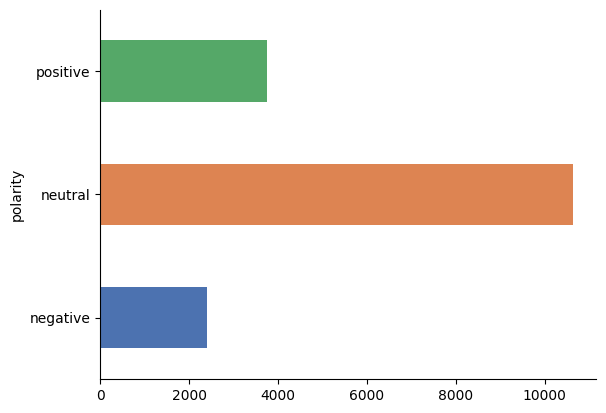

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df.groupby('polarity').size().plot(kind='barh', color=sns.color_palette("deep"))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## Train / Validate / Test Split

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_val_split(df, name) :
  train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['polarity'], random_state=42)
  val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['polarity'], random_state=42)

  print(f"{name} Data Split: \n")
  print("Train size:", len(train_df))
  print("Validation size:", len(val_df))
  print("Test size:", len(test_df))
  return train_df, val_df, test_df

### Twitter data split

In [ ]:
train_df_twitter, val_df_twitter, test_df_twitter = train_test_val_split(twitter_df, "Twitter")

Twitter Data Split: 

Train size: 9544
Validation size: 1193
Test size: 1194


### News data split

In [ ]:
train_df_news, val_df_news, test_df_news = train_test_val_split(news_df, "News")

News Data Split: 

Train size: 3876
Validation size: 485
Test size: 485


### Combined data split

In [ ]:
train_df_combined, val_df_combined, test_df_combined = train_test_val_split(combined_df, "Combined")

Combined Data Split: 

Train size: 13421
Validation size: 1678
Test size: 1678


In [ ]:
def df_to_dataset(train_df, val_df, test_df):
    # Create datasets from pandas
    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
    test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

    # Wrap them in a DatasetDict
    return DatasetDict({
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    })

In [ ]:
#dataset = df_to_dataset(train_df_twitter, test_df_twitter, val_df_twitter)
dataset = df_to_dataset(train_df_combined, val_df_combined, test_df_combined)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'polarity'],
        num_rows: 13421
    })
    validation: Dataset({
        features: ['text', 'polarity'],
        num_rows: 1678
    })
    test: Dataset({
        features: ['text', 'polarity'],
        num_rows: 1678
    })
})

# Training

In [ ]:
label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}
id2label = {v: k for k, v in label2id.items()}

num_labels = len(label2id)  # 3

In [ ]:
def encode_labels(examples):
    """Convert string labels (negative, neutral, positive) to int."""
    return {"labels": [label2id[p] for p in examples["polarity"]]}

dataset = dataset.map(encode_labels, batched=True)

Map:   0%|          | 0/13421 [00:00<?, ? examples/s]

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

In [ ]:
model_id = "answerdotai/ModernBERT-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",  # or "longest"
        truncation=True,
        max_length=128
    )

dataset = dataset.map(tokenize_function, batched=True)
#dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text", "polarity"])

Map:   0%|          | 0/13421 [00:00<?, ? examples/s]

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

When creating Trainer object, pass model_init instead of model. This way, each trial will start from a freshly initialized model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def model_init():
    """Re-initialize model for each hyperparameter search trial."""
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        label2id=label2id,
        id2label=id2label
    )

from transformers import AutoConfig

def model_init(trial=None):
    """
    If `trial` is provided (when doing hyperparameter search),
    fetch the dropout from the trial parameters. Otherwise, default to 0.1 or any default you like.
    """
    dropout = 0.1  # default
    if trial is not None:
        # The Trainer will inject a `trial` argument if `model_init` has it
        if hasattr(trial, "params") and "dropout" in trial.params:
            dropout = trial.params["dropout"]

    #Load config, set dropout
    config = AutoConfig.from_pretrained(model_id)
    config.hidden_dropout_prob = dropout            # For hidden layers
    config.attention_probs_dropout_prob = dropout   # For attention layers

    #Create model with custom config
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        config=config,
        num_labels=num_labels,
        label2id=label2id,
        id2label=id2label
    )
    return model


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer

def compute_metrics(eval_pred):
    """
    eval_pred is a namedtuple with:
      - predictions: model outputs (logits or probabilities)
      - label_ids: the true labels
    """
    predictions, labels = eval_pred
    # Get the predicted class by taking the argmax on the last dimension
    preds = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Training Args

In [ ]:
from transformers import SchedulerType, TrainingArguments

training_args = TrainingArguments(
    output_dir="modernbert-financial-sentiment",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    bf16=False,           # Use bfloat16 if GPU supports it i.e. A100
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=2,
    optim="adamw_torch_fused",  # if environment supports it
    push_to_hub=True,  # Enable push to hub
    hub_model_id="xxxxx",
    hub_token="xxxxx",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Hyperparameter Search Function

In [ ]:
newfrom transformers import Trainer
from ray import tune

def hp_space_optuna(trial):
    return {
        # Learning rate: from 1e-5 to 3e-4 on a log scale
        # Reasoning: This covers typical fine-tuning LR for transformers (1e-5)
        # up to a moderately aggressive range (3e-4).
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 3e-4, log=True),

        # Number of epochs: from 2 to 8
        # Reasoning: For many NLP tasks, 2 epochs can sometimes suffice,
        # while 8 covers a broader range if your data is small or needs more passes.
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 3),

        # Batch size: choose among [8, 16, 32]
        # Reasoning: 8 is often safe on smaller GPUs, 16 is standard,
        # and 32 can help converge faster if memory allows.
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [8, 16, 32]
        ),

        # Weight decay: from 0.0 to 0.1
        # Reasoning: 0 typically means no weight decay,
        # but some tasks benefit from mild regularization like 0.01–0.1.
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),

        # Dropout: from 0.0 to 0.3
        # Reasoning: 0 means no dropout, while 0.3 is decently high without being extreme.
        "dropout": trial.suggest_float("dropout", 0.0, 0.3),

        # Warmup ratio: from 0.0 to 0.2
        # Reasoning: 0 means no warmup; 0.1–0.2 can help stabilize training at the start.
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),

        # Learning rate scheduler: pick from a few common scheduler types
        # Reasoning: 'linear' is standard; 'cosine' can help some models converge more smoothly;
        # 'polynomial' is another popular choice.
        "lr_scheduler_type": trial.suggest_categorical(
            "lr_scheduler_type", [SchedulerType.LINEAR, SchedulerType.COSINE, SchedulerType.POLYNOMIAL]
        ),

        # Adam epsilon: 1e-8 to 1e-6, log scale
        # Reasoning: The default in many HF scripts is 1e-8, but going slightly higher
        # (like 1e-6) can help with numerical stability in some setups.
        "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True),
    }



## Create Trainer

In [ ]:
trainer = Trainer(
    #model=model_init,
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameter Search

In [ ]:
best_run = trainer.hyperparameter_search(
    direction="maximize",           # or "minimize"
    hp_space=hp_space_optuna,       # the function defined above
    backend="optuna",               # or "ray", "sigopt", "wandb", etc.
    n_trials=5,                    # how many trials to run
    compute_objective=lambda metrics: metrics["eval_accuracy"],  # which metric to optimize
)

[I 2025-01-14 01:44:00,788] A new study created in memory with name: no-name-b86eab55-5f1e-4b65-b422-cd9c75017586
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.359378,0.856377,0.854300,0.854428,0.856377
2,0.479900,0.341022,0.889750,0.889450,0.889272,0.889750


[I 2025-01-14 01:59:34,487] Trial 0 finished with value: 0.8897497020262217 and parameters: {'learning_rate': 0.000130710421291084, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.03027147362346292, 'dropout': 0.2945075464984895, 'warmup_ratio': 0.16437763421148122, 'lr_scheduler_type': 'linear', 'adam_epsilon': 2.434512125659637e-07}. Best is trial 0 with value: 0.8897497020262217.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂██
train/global_step,▁▂██
train/grad_norm,▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.399000,0.371437,0.878427,0.877154,0.878700,0.878427
2,0.210500,0.484192,0.885578,0.884544,0.884642,0.885578


[I 2025-01-14 02:17:55,451] Trial 1 finished with value: 0.8855780691299165 and parameters: {'learning_rate': 3.074987217774767e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.07691241332138511, 'dropout': 0.2907986120031344, 'warmup_ratio': 0.1614840440413937, 'lr_scheduler_type': 'cosine', 'adam_epsilon': 4.528050525370297e-07}. Best is trial 0 with value: 0.8897497020262217.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▃▄▅▆▇██
train/global_step,▁▂▃▄▅▆▇██
train/grad_norm,▁▂▃▆█▂


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.376100,0.339269,0.881406,0.880324,0.880502,0.881406
2,0.196600,0.489612,0.887366,0.887089,0.886905,0.887366


[I 2025-01-14 02:36:07,603] Trial 2 finished with value: 0.8873659117997617 and parameters: {'learning_rate': 4.064551738596914e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.03968036353710822, 'dropout': 0.24117201912339123, 'warmup_ratio': 0.035379217141246234, 'lr_scheduler_type': 'polynomial', 'adam_epsilon': 6.870937420002894e-07}. Best is trial 0 with value: 0.8897497020262217.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▃▄▅▆▇██
train/global_step,▁▂▃▄▅▆▇██
train/grad_norm,▆█▅▆▅▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.740400,0.465809,0.834923,0.835505,0.836237,0.834923
2,0.295800,0.395457,0.870083,0.867828,0.868136,0.870083


[I 2025-01-14 02:53:39,383] Trial 3 finished with value: 0.8700834326579261 and parameters: {'learning_rate': 0.00025521924750938495, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.019216183889368046, 'dropout': 0.14773382828941314, 'warmup_ratio': 0.14829847970081875, 'lr_scheduler_type': 'polynomial', 'adam_epsilon': 4.432040666472484e-08}. Best is trial 0 with value: 0.8897497020262217.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▃▄▇██
train/global_step,▁▃▄▇██
train/grad_norm,▁▅█


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.613400,0.333443,0.874851,0.873988,0.873684,0.874851
2,0.198300,0.368632,0.880810,0.880276,0.880036,0.880810


[I 2025-01-14 03:12:46,061] Trial 4 finished with value: 0.8808104886769964 and parameters: {'learning_rate': 3.0727872305019286e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.09625464285160057, 'dropout': 0.14986636674008116, 'warmup_ratio': 0.1440426494220562, 'lr_scheduler_type': 'polynomial', 'adam_epsilon': 1.0111063924919479e-08}. Best is trial 0 with value: 0.8897497020262217.


In [ ]:
print(best_run)
# best_run.hyperparameters -> dict of best hyperparameters
# best_run.objective -> best metric value achieved
# best_run.trial_id -> ID of the best trial

BestRun(run_id='0', objective=0.8897497020262217, hyperparameters={'learning_rate': 0.000130710421291084, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.03027147362346292, 'dropout': 0.2945075464984895, 'warmup_ratio': 0.16437763421148122, 'lr_scheduler_type': 'linear', 'adam_epsilon': 2.434512125659637e-07}, run_summary=None)


## Run Trainer with best hyperparameters

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.359378,0.856377,0.854300,0.854428,0.856377
2,0.479900,0.341022,0.889750,0.889450,0.889272,0.889750


TrainOutput(global_step=840, training_loss=0.36816159202938986, metrics={'train_runtime': 896.984, 'train_samples_per_second': 29.925, 'train_steps_per_second': 0.936, 'total_flos': 2286671378360832.0, 'train_loss': 0.36816159202938986, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

# Evaluate

In [ ]:
metrics = trainer.evaluate(dataset["test"])
print("Test Metrics:", metrics)

Test Metrics: {'eval_loss': 0.30202439427375793, 'eval_accuracy': 0.8831942789034565, 'eval_f1': 0.8825909524907293, 'eval_precision': 0.8822860966690316, 'eval_recall': 0.8831942789034565, 'eval_runtime': 19.6576, 'eval_samples_per_second': 85.361, 'eval_steps_per_second': 10.683, 'epoch': 2.0}


In [ ]:
predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)

# Compare first sample predicted label vs actual
print("Predicted label:", id2label[preds[0]])
print("Actual label:   ", id2label[dataset["test"][0]["labels"]])

Predicted label: positive
Actual label:    positive


### Save mislabelled

In [ ]:
# Identify indices where predicted != actual
mislabelled_indices = np.where(pred_labels != true_labels)[0]

# Gather mislabelled samples
rows = []
for i in mislabelled_indices:
    text = dataset["test"]["text"][i]  # original text
    predicted_label = id2label[pred_labels[i]]
    actual_label = id2label[true_labels[i]]
    rows.append({
        "text": text,
        "predicted": predicted_label,
        "actual": actual_label,
    })

# Convert to DataFrame & save as CSV
mislabelled_df = pd.DataFrame(rows)
mislabelled_df.to_csv("mislabelled_samples.csv", index=False)

print("Mislabelled samples saved to mislabelled_samples.csv!")

Mislabelled samples saved to mislabelled_samples.csv!


# Display Results

### Confusion Matrix

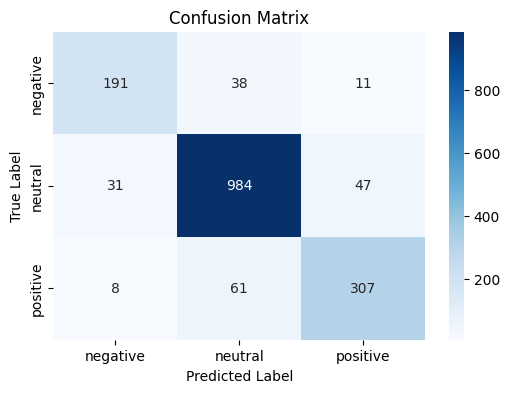

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# After you've done predictions on the test set:
predictions = trainer.predict(dataset["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the dataset
true_labels = np.array(dataset["test"]["labels"])

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Convert the id2label dict into a list of labels in the right order
# (label2id = {"negative": 0, "neutral": 1, "positive": 2})
label_order = [id2label[i] for i in range(len(id2label))]

#Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_order,
            yticklabels=label_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("confusion_matrix.png")
plt.show()

## Distribution of predicted probabilities

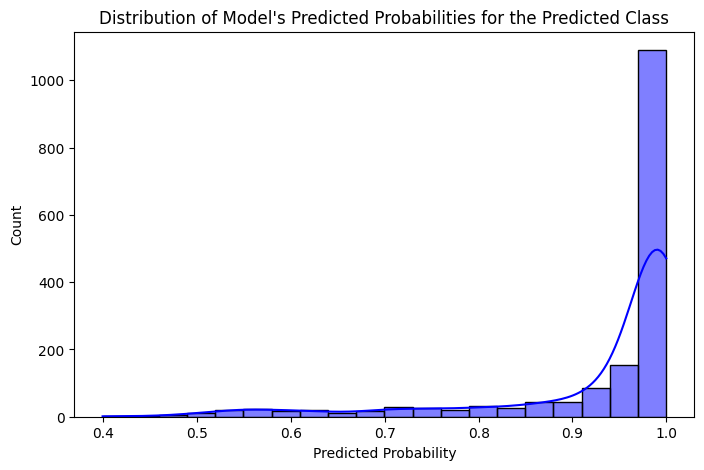

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F

logits = predictions.predictions
predicted_probs = F.softmax(torch.tensor(logits), dim=-1).numpy()

#Get the max probability for each sample (the predicted class probability)
max_probs = np.max(predicted_probs, axis=1)

plt.figure(figsize=(8, 5))
sns.histplot(max_probs, kde=True, bins=20, color="blue")
plt.title("Distribution of Model's Predicted Probabilities for the Predicted Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig("predicted_probabilities_distribution.png")
plt.show()

## Text length vs model accuracy

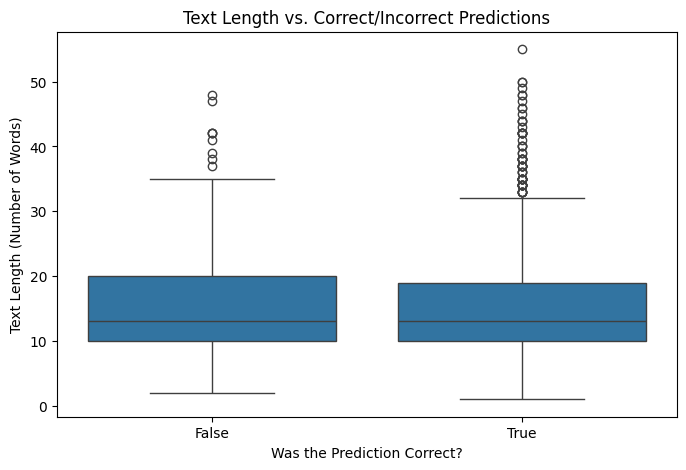

In [ ]:
import pandas as pd
from tqdm import tqdm

records = []
for i in range(len(test_data)):
    text = test_data[i]["text"]
    text_length = len(text.split())
    correct = (pred_labels[i] == true_labels[i])
    records.append({"text_length": text_length, "correct": correct})

df_lengths = pd.DataFrame(records)

plt.figure(figsize=(8, 5))
sns.boxplot(x="correct", y="text_length", data=df_lengths)
plt.title("Text Length vs. Correct/Incorrect Predictions")
plt.xlabel("Was the Prediction Correct?")
plt.ylabel("Text Length (Number of Words)")
plt.savefig("text_length_vs_accuracy.png")
plt.show()

## Per-Class Accuracy (Bar Chart)

<ipython-input-56-37727b9e539a>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="Blues_d")


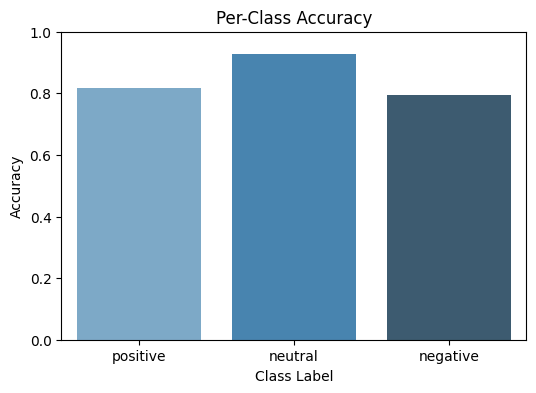

In [ ]:
from collections import defaultdict

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

counts = defaultdict(int)
correct_counts = defaultdict(int)

for i, true in enumerate(true_labels):
    counts[true] += 1
    if pred_labels[i] == true:
        correct_counts[true] += 1

per_class_accuracy = {
    id2label[i]: correct_counts[i] / counts[i] for i in counts
}

labels = list(per_class_accuracy.keys())
accuracies = list(per_class_accuracy.values())

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=accuracies, palette="Blues_d")
plt.ylim([0, 1])
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Class Label")
plt.savefig("per_class_accuracy.png")
plt.show()

## ROC / AUC Curves (Multi-class)

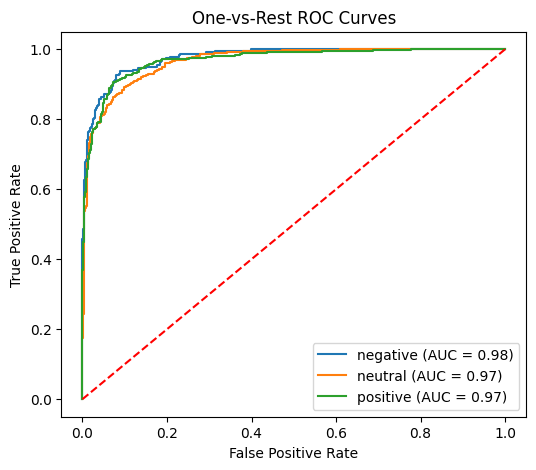

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For multi-class, do one-vs-rest approach
fpr = {}
tpr = {}
roc_auc = {}
for i, label_name in id2label.items():
    # Binarize the labels: 1 if it's this class, else 0
    binary_true = (true_labels == i).astype(int)
    scores = predicted_probs[:, i]
    fpr[i], tpr[i], _ = roc_curve(binary_true, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i, label_name in id2label.items():
    plt.plot(fpr[i], tpr[i], label=f'{label_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'r--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc="lower right")
plt.savefig("roc_curves.png")
plt.show()